# 03c - BigQuery ML (BQML) - Random Forest For Classification

In this notebook, BigQuery ML (BQML) is used to create a random forest model (using XGBoost).

**Random Forest**

A random forest model is an ensemble of decision trees using bagging:
- Decision Tree: A supervised learning approach which finds splits in features that represent decisions on predicted level of the target variable.
- Ensemble of Trees: Combining trees to form the sum of predictions from multiple trees 
- Bagging: Parallel training on a random subset of data (observations and features) done with replacement (each subset is randomly sampled from the full set)

Reference:
- [Decision Trees](https://en.wikipedia.org/wiki/Decision_tree_learning)
- [Bagging, or Bootstrap Aggregating](https://en.wikipedia.org/wiki/Bootstrap_aggregating)
- [Random Forest](https://en.wikipedia.org/wiki/Random_forest)
- [Supervised Learning](https://en.wikipedia.org/wiki/Supervised_learning)

**BigQuery ML (BQML)**

BigQuery has a number of machine learning algorithms callable directly from SQL.  This gives the convenience of using the common language of `SQL` with statments like `CREATE MODEL …`.  The library of available models is constantly growing and covers supervised, unsupervised, and time series methods as well as functions for evaluation - even anomaly detection from results, explainability and hyperparameter tuning.  A great starting point for seeing the scope of available methods is the [user journey for models](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-e2e-journey).

**Prerequisites:**
- [01 - BigQuery - Table Data Source](../01%20-%20Data%20Sources/01%20-%20BigQuery%20-%20Table%20Data%20Source.ipynb)

**Resources:**
-  [BigQuery ML (BQML) Overview](https://cloud.google.com/bigquery-ml/docs/introduction)
-  [Overview of BQML methods and workflows](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-e2e-journey)
- [BigQuery](https://cloud.google.com/bigquery)
    - [Documentation:](https://cloud.google.com/bigquery/docs/query-overview)
    - [API:](https://cloud.google.com/bigquery/docs/reference/libraries-overview)
        - [Clients](https://cloud.google.com/bigquery/docs/reference/libraries)
            - [Python SDK:](https://github.com/googleapis/python-bigquery)
            - [Python Library Reference:](https://cloud.google.com/python/docs/reference/bigquery/latest)
- [Vertex AI](https://cloud.google.com/vertex-ai)
    - [Documentation:](https://cloud.google.com/vertex-ai/docs/start/introduction-unified-platform)
    - [API:](https://cloud.google.com/vertex-ai/docs/reference)
        - [Clients:](https://cloud.google.com/vertex-ai/docs/start/client-libraries)
            - [Python SDK:](https://github.com/googleapis/python-aiplatform)
            - [Python Library Reference:](https://cloud.google.com/python/docs/reference/aiplatform/latest)

**Conceptual Flow & Workflow**
<p align="center">
  <img alt="Conceptual Flow" src="../architectures/slides/03c_arch.png" width="45%">
&nbsp; &nbsp; &nbsp; &nbsp;
  <img alt="Workflow" src="../architectures/slides/03c_console.png" width="45%">
</p>

---
## Setup

inputs:

In [2]:
project = !gcloud config get-value project
PROJECT_ID = project[0]
PROJECT_ID

'statmike-mlops-349915'

In [53]:
REGION = 'us-central1'
EXPERIMENT = '03c'
SERIES = '03'

# source data
BQ_PROJECT = PROJECT_ID
BQ_DATASET = 'fraud'
BQ_TABLE = 'fraud_prepped'

# Resources for serving BigQuery Model Exports
TF_DEPLOY_IMAGE = 'us-docker.pkg.dev/vertex-ai/prediction/tf2-cpu.2-3:latest'
XGB_DEPLOY_IMAGE = 'us-docker.pkg.dev/vertex-ai/prediction/xgboost-cpu.0-82:latest'

# Resources for serving BigQuery Model Exports
DEPLOY_COMPUTE = 'n1-standard-4'

# Model Training
VAR_TARGET = 'Class'
VAR_OMIT = 'transaction_id' # add more variables to the string with space delimiters

packages:

In [54]:
from google.cloud import bigquery
from google.cloud import aiplatform
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn import metrics

from google.api import httpbody_pb2
import json

clients:

In [55]:
bq = bigquery.Client()
aiplatform.init(project=PROJECT_ID, location=REGION)

parameters:

In [6]:
TIMESTAMP = datetime.now().strftime("%Y%m%d%H%M%S")
BUCKET = PROJECT_ID
URI = f"gs://{BUCKET}/{SERIES}/{EXPERIMENT}"
RUN_NAME = f'run-{TIMESTAMP}'

BQ_MODEL = f'{SERIES}_{EXPERIMENT}_{TIMESTAMP}'

environment:

In [56]:
DIR = f"temp/{EXPERIMENT}"

!rm -rf {DIR}
!mkdir -p {DIR}

---
## Review Data

The data source here was prepared in [01 - BigQuery - Table Data Source](../01%20-%20Data%20Sources/01%20-%20BigQuery%20-%20Table%20Data%20Source.ipynb).  In this notebook we will use prepared BigQuery table to build a model with BigQuery ML (BQML).

This is a table of 284,807 credit card transactions classified as fradulant or normal in the column `Class`.  In order protect confidentiality, the original features have been transformed using [principle component analysis (PCA)](https://en.wikipedia.org/wiki/Principal_component_analysis) into 28 features named `V1, V2, ... V28` (float).  Two descriptive features are provided without transformation by PCA:
- `Time` (integer) is the seconds elapsed between the transaction and the earliest transaction in the table
- `Amount` (float) is the value of the transaction

The data preparation included added splits for machine learning with a column named `splits` with 80% for training (`TRAIN`), 10% for validation (`VALIDATE`) and 10% for testing (`TEST`).  Additionally, a unique identifier was added to each transaction, `transaction_id`.  

Review the number of records for each level of Class (VAR_TARGET) for each of the data splits:

In [7]:
query = f"""
SELECT splits, {VAR_TARGET}, count(*) as n
FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
GROUP BY splits, {VAR_TARGET}
"""
bq.query(query = query).to_dataframe()

,splits,Class,n
0,TEST,0,28455
1,TEST,1,47
2,TRAIN,0,227664
3,TRAIN,1,397
4,VALIDATE,0,28196
5,VALIDATE,1,48


Further review the balance of the target variable (VAR_TARGET) for each split as a percentage of the split:

In [8]:
query = f"""
WITH
    COUNTS as (SELECT splits, {VAR_TARGET}, count(*) as n FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}` GROUP BY splits, {VAR_TARGET})
    
SELECT *,
    SUM(n) OVER() as total,
    SAFE_DIVIDE(n, SUM(n) OVER(PARTITION BY {VAR_TARGET})) as n_pct_class,
    SAFE_DIVIDE(n, SUM(n) OVER(PARTITION BY splits)) as n_pct_split,
    SAFE_DIVIDE(SUM(n) OVER(PARTITION BY {VAR_TARGET}), SUM(n) OVER()) as class_pct_total
FROM COUNTS
"""
review = bq.query(query = query).to_dataframe()
review

,splits,Class,n,total,n_pct_class,n_pct_split,class_pct_total
0,TEST,0,28455,284807,0.100083,0.998351,0.998273
1,TEST,1,47,284807,0.095528,0.001649,0.001727
2,TRAIN,0,227664,284807,0.800746,0.998259,0.998273
3,TRAIN,1,397,284807,0.806911,0.001741,0.001727
4,VALIDATE,0,28196,284807,0.099172,0.998301,0.998273
5,VALIDATE,1,48,284807,0.097561,0.001699,0.001727


---
## This Run

In [9]:
print(f'This run with create BQML model: {BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}')
print(f'The Timestamp Is: {TIMESTAMP}')

This run with create BQML model: statmike-mlops-349915.fraud.03_03c_20221003125950
The Timestamp Is: 20221003125950


---
## Train Model

Use BigQuery ML to train multiclass random forest model using XGBoost:
- [Random Forest](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-create-random-forest) with BigQuery ML (BQML)
- This uses the `splits` column that notebook `01` created
- `data_split_method = CUSTOM` uses the column in `data_split_col` to assign training data for `FALSE` values and evaluation data for `TRUE` values.
    - in this example the `WHERE splits != 'TEST'` statement filters out the test data and
    - the `CASE` statement maps training data to FALSE and validation data to TRUE

In [7]:
query = f"""
CREATE MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`
OPTIONS
    (model_type = 'RANDOM_FOREST_CLASSIFIER',
        auto_class_weights = TRUE,
        input_label_cols = ['{VAR_TARGET}'],
        enable_global_explain = TRUE,
        data_split_col = 'custom_splits',
        data_split_method = 'CUSTOM',
        num_parallel_tree = 200,
        #early_stop = TRUE,
        #min_rel_progress = 0.01,
        tree_method = 'HIST',
        subsample = 0.85,
        colsample_bytree = 0.9
    ) AS
SELECT * EXCEPT({','.join(VAR_OMIT.split())}, splits),
    CASE
        WHEN splits = 'TRAIN' THEN FALSE
        ELSE TRUE
    END AS custom_splits
FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
WHERE splits != 'TEST'
"""
job = bq.query(query = query)
job.result()

In [8]:
(job.ended-job.started).total_seconds()

1815.168

Add labels to the model in BigQuery:

In [9]:
model = bq.get_model(f'{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}')
model.labels = {'series' : f'{SERIES}', 'experiment' : f'{EXPERIMENT}'}
model = bq.update_model(model, ['labels'])

Review the Model Inputs, the feature information, with [ML.FEATURE_INFO](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-feature):

In [34]:
feature_info = bq.query(
    query = f"""
        SELECT *
        FROM ML.FEATURE_INFO(MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`)
        """
).to_dataframe()
feature_info

,input,min,max,mean,median,stddev,category_count,null_count,dimension
0,Time,0.000000,172792.000000,94811.116749,85296.000000,47493.531641,NaN,0,NaN
1,V1,-56.407510,2.454930,-0.000215,0.032951,1.958173,NaN,0,NaN
2,V2,-72.715728,22.057729,0.000316,0.053255,1.649662,NaN,0,NaN
3,V3,-48.325589,9.382558,-0.000525,0.188378,1.520173,NaN,0,NaN
4,V4,-5.600607,16.875344,0.000695,-0.038436,1.415309,NaN,0,NaN
5,V5,-113.743307,34.801666,-0.001264,-0.059656,1.381807,NaN,0,NaN
6,V6,-26.160506,73.301626,0.002089,-0.274778,1.334135,NaN,0,NaN
7,V7,-43.557242,120.589494,-0.000721,0.033597,1.245465,NaN,0,NaN
8,V8,-73.216718,19.168327,-0.001064,0.025557,1.205023,NaN,0,NaN
9,V9,-13.434066,15.594995,0.001406,-0.054755,1.100121,NaN,0,NaN


Review the iterations from training with [ML.TRAINING_INFO](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-train):

In [10]:
history = bq.query(
    query = f"""
        SELECT *
        FROM ML.TRAINING_INFO(MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`)"""
).to_dataframe()
history

,training_run,iteration,loss,eval_loss,learning_rate,duration_ms
0,0,1,0.137537,0.29586,1.0,123270


### Check out this model in BigQuery Console:
- Make sure project selected is the one from this notebook
- Under Explore, expand this project and dataset
- Expand Models and select the model create here

In [11]:
print(f'BigQuery Console for Project:\nhttps://console.cloud.google.com/bigquery?project={PROJECT_ID}')

BigQuery Console for Project:
https://console.cloud.google.com/bigquery?project=statmike-mlops-349915


In [12]:
print(f'Direct link to the model in BigQuery:\nhttps://console.cloud.google.com/bigquery?project={PROJECT_ID}&ws=!1m5!1m4!5m3!1s{PROJECT_ID}!2s{BQ_DATASET}!3s{BQ_MODEL}')

Direct link to the model in BigQuery:
https://console.cloud.google.com/bigquery?project=statmike-mlops-349915&ws=!1m5!1m4!5m3!1sstatmike-mlops-349915!2sfraud!3s03_03c_20221003125950


---
## Evaluate Model

### Metrics

Review the model evaluation statistics on the splits with [ML.EVALUATE](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-evaluate):

In [13]:
query = f"""
SELECT 'TEST' as SPLIT, * FROM ML.EVALUATE (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,
    (SELECT * FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}` WHERE SPLITS='TEST'))
UNION ALL
SELECT 'VALIDATE' as SPLIT, * FROM ML.EVALUATE (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,
    (SELECT * FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}` WHERE SPLITS='VALIDATE'))
UNION ALL
SELECT 'TRAIN' as SPLIT, * FROM ML.EVALUATE (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,
    (SELECT * FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}` WHERE SPLITS='TRAIN'))
"""
bq.query(query = query).to_dataframe()

,SPLIT,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,TEST,0.780000,0.829787,0.999333,0.804124,0.129526,0.973328
1,VALIDATE,0.722222,0.812500,0.999150,0.764706,0.129857,0.991630
2,TRAIN,0.794000,1.000000,0.999548,0.885173,0.129008,1.000000


### Confusion Matrix

Review the confusion matrix for each split with [ML.CONFUSION_MATRIX](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-confusion):

In [14]:
query = f"""
SELECT *
FROM ML.CONFUSION_MATRIX (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,(
    SELECT *
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
    WHERE splits = 'TRAIN')
  )
"""
bq.query(query = query).to_dataframe()

,expected_label,_0,_1
0,0,227561,103
1,1,0,397


In [15]:
query = f"""
SELECT *
FROM ML.CONFUSION_MATRIX (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,(
    SELECT *
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
    WHERE splits = 'VALIDATE')
  )
"""
bq.query(query = query).to_dataframe()

,expected_label,_0,_1
0,0,28181,15
1,1,9,39


In [16]:
query = f"""
SELECT *
FROM ML.CONFUSION_MATRIX (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,(
    SELECT *
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
    WHERE splits = 'TEST')
  )
"""
bq.query(query = query).to_dataframe()

,expected_label,_0,_1
0,0,28444,11
1,1,8,39


### ROC Curve

Retrieve the ROC Curve for each split using [ML.ROC_CURVE](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-roc):

In [17]:
query = f"""
SELECT *
FROM ML.ROC_CURVE (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,(
    SELECT *
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
    WHERE splits = 'TRAIN')
  )
ORDER BY false_positive_rate
"""
train_roc = bq.query(query = query).to_dataframe()
train_roc.head()

,threshold,recall,false_positive_rate,true_positives,false_positives,true_negatives,false_negatives
0,0.880593,0.513854,0.000136,204,31,227633,193
1,0.146442,1.000000,0.008359,397,1903,225761,0
2,0.131668,1.000000,0.018316,397,4170,223494,0
3,0.127214,1.000000,0.028204,397,6421,221243,0
4,0.124934,1.000000,0.038416,397,8746,218918,0


In [18]:
query = f"""
SELECT *
FROM ML.ROC_CURVE (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,(
    SELECT *
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
    WHERE splits = 'VALIDATE')
  )
ORDER BY false_positive_rate
"""
val_roc = bq.query(query = query).to_dataframe()
val_roc.head()

,threshold,recall,false_positive_rate,true_positives,false_positives,true_negatives,false_negatives
0,0.880593,0.395833,0.000106,19,3,28193,29
1,0.148931,0.875000,0.008654,42,244,27952,6
2,0.133510,0.958333,0.018549,46,523,27673,2
3,0.128562,0.979167,0.028373,47,800,27396,1
4,0.125843,0.979167,0.038481,47,1085,27111,1


In [19]:
query = f"""
SELECT *
FROM ML.ROC_CURVE (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,(
    SELECT *
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
    WHERE splits = 'TEST')
  )
ORDER BY false_positive_rate
"""
test_roc = bq.query(query = query).to_dataframe()
test_roc.head()

,threshold,recall,false_positive_rate,true_positives,false_positives,true_negatives,false_negatives
0,0.880593,0.468085,0.000141,22,4,28451,25
1,0.149221,0.893617,0.008505,42,242,28213,5
2,0.132674,0.893617,0.018696,42,532,27923,5
3,0.128083,0.893617,0.028571,42,813,27642,5
4,0.125751,0.914894,0.038693,43,1101,27354,4


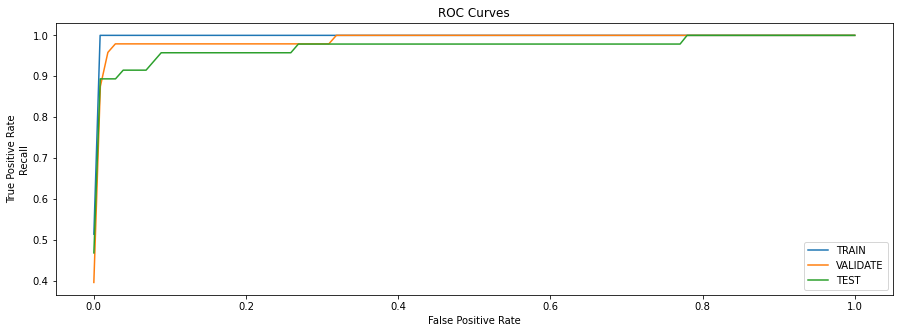

In [20]:
plt.figure(figsize=(15,5))
plt.plot(train_roc['false_positive_rate'], train_roc['recall'], label='TRAIN')
plt.plot(val_roc['false_positive_rate'], val_roc['recall'], label='VALIDATE')
plt.plot(test_roc['false_positive_rate'], test_roc['recall'], label='TEST')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate\nRecall')
plt.title('ROC Curves')
plt.legend()
plt.show()

---
## Predictions With BigQuery ML (BQML)

Create a pandas dataframe with retrieved predictions for the test data in the table using [ML.PREDICT](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-predict):

In [21]:
query = f"""
SELECT *
FROM ML.PREDICT (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,(
    SELECT *
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
    WHERE splits = 'TEST')
  )
"""
pred = bq.query(query = query).to_dataframe()

Review columns from the predictions - note that the query added columns with prefix `predicted_`

In [22]:
pred.columns

Index(['predicted_Class', 'predicted_Class_probs', 'Time', 'V1', 'V2', 'V3',
       'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14',
       'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24',
       'V25', 'V26', 'V27', 'V28', 'Amount', 'Class', 'transaction_id',
       'splits'],
      dtype='object')

Print the first few rows for the columns related to the actual and predicted values:

In [23]:
pred[[VAR_TARGET, f'predicted_{VAR_TARGET}', f'predicted_{VAR_TARGET}_probs', 'splits']].head()

,Class,predicted_Class,predicted_Class_probs,splits
0,0,0,"[{'label': 1, 'prob': 0.11956964433193207}, {'...",TEST
1,0,0,"[{'label': 1, 'prob': 0.11924473196268082}, {'...",TEST
2,0,0,"[{'label': 1, 'prob': 0.11981116235256195}, {'...",TEST
3,0,0,"[{'label': 1, 'prob': 0.12139012664556503}, {'...",TEST
4,0,0,"[{'label': 1, 'prob': 0.11925367265939713}, {'...",TEST


Notice the nested dictionary for predicted probabilities.  In BigQuery this is a Record type structure with nested fields for `label` and `prop`.  This is returned to the pandas dataframe as a nested dictionary.

The following code sorts the dictionary for the first record by `prob`:

In [24]:
exec('temp = pred.predicted_'+VAR_TARGET+'_probs[0]')
[sorted(x, key = lambda x: x['label']) for x in [temp]]

[[{'label': 0, 'prob': 0.8804303407669067},
  {'label': 1, 'prob': 0.11956964433193207}]]

---
## Custom Eval Metrics
Retrieve the predictions to a local dataframe and use [scikit-learn](https://scikit-learn.org/stable/index.html) metrics [fuctions](https://scikit-learn.org/stable/modules/model_evaluation.html) to do model evaluation.

In [30]:
metrics.confusion_matrix(pred[f'{VAR_TARGET}'], pred[f'predicted_{VAR_TARGET}'])

array([[28444,    11],
       [    8,    39]])

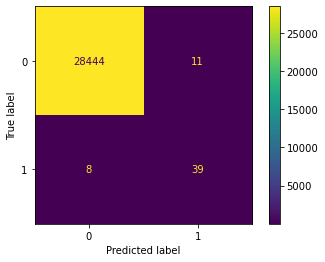

In [31]:
disp = metrics.ConfusionMatrixDisplay(
    confusion_matrix = metrics.confusion_matrix(pred[f'{VAR_TARGET}'], pred[f'predicted_{VAR_TARGET}'])
)
disp.plot()

In [32]:
metrics.accuracy_score(pred[f'{VAR_TARGET}'], pred[f'predicted_{VAR_TARGET}'])

0.9993333801136762

In [33]:
print(metrics.classification_report(pred[f'{VAR_TARGET}'], pred[f'predicted_{VAR_TARGET}']))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28455
           1       0.78      0.83      0.80        47

    accuracy                           1.00     28502
   macro avg       0.89      0.91      0.90     28502
weighted avg       1.00      1.00      1.00     28502



---
## Explanations
[Built-in](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-xai-overview) capabilities to understand how features contributed to predictions both individually (local) and overall (global).

### Local Explainability
Retrieve feature attribution values to interpret each features contribution to a prediction relative to the baseline prediction using [ML.EXPLAIN_PREDICT](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-explain-predict).

In [ ]:
query = f"""
SELECT *
FROM ML.EXPLAIN_PREDICT (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,(
    SELECT *
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
    WHERE splits = 'TEST'), STRUCT(10 as top_k_features)
  )
"""
explain = bq.query(query = query).to_dataframe()

In [ ]:
explain.head()

Create a plot of feature attributions for a single prediction:

In [ ]:
explanation = explain.iloc[0]['top_feature_attributions']

In [ ]:
features = []
scores = []
for k in explanation:
    features.append(k['feature'])
    scores.append(k['attribution'])
features = [x for _, x in sorted(zip(scores, features))]
scores = sorted(scores)

plt.figure(figsize=(15,5))
plt.barh(features, scores)
plt.title('Feature Attribution for Prediction')
plt.show()

### Global Explainability
Retrieve the influence of each feature on the model with [ML.GLOBAL_EXPLAIN](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-global-explain).  

In [ ]:
query = f"""
SELECT *
FROM ML.GLOBAL_EXPLAIN (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`)
"""
gexplain = bq.query(query = query).to_dataframe()

In [ ]:
gexplain.head()

In [ ]:
plt.figure(figsize=(15,8))
plt.barh(gexplain['feature'], gexplain['attribution'])
plt.title('Global Influence')
plt.xlabel('Attribution')
#plt.ylabel('Feature')
plt.show()

### Feature Importance

Retrieve the [XGBoost feature importances](https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBRegressor.feature_importances_) for the model using [ML.FEATURE_IMPORTANCE](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-importance).
- importance_weight: the number of splits the feature was used in across all trees
- importance_gain: the improvement in accuracy due to splits using the feature
- importance_cover: the number of rows of data covered by splits using the feature

In [ ]:
query = f"""
SELECT *
FROM ML.FEATURE_IMPORTANCE (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`)
"""
feature_importance = bq.query(query = query).to_dataframe()

In [ ]:
feature_importance

---
## Serving With Vertex AI

This demonstration shows the process of exporting and registering a BQML model with Vertex AI Model Registry.  To directly integrate BQML with Vertex AI Model Registry it is now (April 1, 2022) possible at model creation time with options `vertex_ai_model_id` and `vertex_ai_model_version_alises`. See the documentation for this direct integration [here](https://cloud.google.com/bigquery-ml/docs/managing-models-vertex).

### Export the BigQuery Model

Reference: [Export the BigQuery Model](https://cloud.google.com/bigquery-ml/docs/exporting-models)

In [ ]:
query = f"""
EXPORT MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`
    OPTIONS (URI = '{URI}/models/{TIMESTAMP}/model')
"""
export = bq.query(query = query)
export.result()

In [ ]:
(export.ended - export.started).total_seconds()

In [40]:
listing = !gsutil ls {URI}/models/{TIMESTAMP}/model
listing

['gs://statmike-mlops-349915/03/03c/models/20221003125950/model/main.py',
 'gs://statmike-mlops-349915/03/03c/models/20221003125950/model/model.bst',
 'gs://statmike-mlops-349915/03/03c/models/20221003125950/model/xgboost_predictor-0.1.tar.gz',
 'gs://statmike-mlops-349915/03/03c/models/20221003125950/model/assets/']

In [41]:
print(f"View the export in the console:\nhttps://console.cloud.google.com/storage/browser/{URI.split('//')[-1]}/models/{TIMESTAMP}/model?project={PROJECT_ID}")

View the export in the console:
https://console.cloud.google.com/storage/browser/statmike-mlops-349915/03/03c/models/20221003125950/model?project=statmike-mlops-349915


### Detect The Model Types Framework

In [42]:
filetype = {'pb': 'TensorFlow', 'bst': 'XGBoost'}

filetypes = [filetype[f.split('.')[-1]] for f in listing if f.split('.')[-1] in ['pb','bst']]
if len(filetypes) == 1:
    framework = filetypes[0]
    print(f'framework = {framework}')
else:
    raise TypeError(f"Model Type Undeteremined!! Review the contents of of 'listing = {listing}'.")

framework = XGBoost


Set the `DEPLOY_IMAGE` based on the framework:

In [43]:
if framework == 'TensorFlow':
    DEPLOY_IMAGE = TF_DEPLOY_IMAGE
elif framework == 'XGBoost':
    DEPLOY_IMAGE = XGB_DEPLOY_IMAGE
    
DEPLOY_IMAGE

'us-docker.pkg.dev/vertex-ai/prediction/xgboost-cpu.0-82:latest'

### Upload The Model To Vertex AI Model Registry

References:
- [aiplatform.Model](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform.Model)

In [44]:
modelmatch = aiplatform.Model.list(filter = f'display_name={SERIES}_{EXPERIMENT} AND labels.series={SERIES} AND labels.experiment={EXPERIMENT}')

upload_model = True
if modelmatch:
    print("Model Already in Registry:")
    if RUN_NAME in modelmatch[0].version_aliases:
        print("This version already loaded, no action taken.")
        upload_model = False
        model = aiplatform.Model(model_name = modelmatch[0].resource_name)
    else:
        print('Loading model as new default version.')
        parent_model =  modelmatch[0].resource_name
else:
    print('This is a new model, adding to model registry as version 1')
    parent_model = ''

if upload_model:
    model = aiplatform.Model.upload(
        display_name = f'{SERIES}_{EXPERIMENT}',
        model_id = f'model_{SERIES}_{EXPERIMENT}',
        parent_model = parent_model,
        serving_container_image_uri = DEPLOY_IMAGE,
        artifact_uri = f"{URI}/models/{TIMESTAMP}/model",
        is_default_version = True,
        version_aliases = [RUN_NAME],
        version_description = RUN_NAME,
        labels = {'series' : f'{SERIES}', 'experiment' : f'{EXPERIMENT}', 'timestamp': f'{TIMESTAMP}', 'run_name' : f'{RUN_NAME}', 'framework' : f'{framework.lower()}'}
    )  

Model Already in Registry:
This version already loaded, no action taken.


In [57]:
model.display_name

'03_03c'

In [58]:
model.resource_name

'projects/1026793852137/locations/us-central1/models/model_03_03c'

In [59]:
print(f"View the model in the Vertex AI Console:\nhttps://console.cloud.google.com/vertex-ai/locations/{REGION}/models/model_{SERIES}_{EXPERIMENT}?project={PROJECT_ID}")

View the model in the Vertex AI Console:
https://console.cloud.google.com/vertex-ai/locations/us-central1/models/model_03_03c?project=statmike-mlops-349915


---
## Online Predictions with Vertex AI Endpoints

### Create/Retrieve An Endpoint
References:
- [aiplatform.Endpoint()](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform.Endpoint)

In [60]:
endpoints = aiplatform.Endpoint.list(filter = f"labels.series={SERIES}")
if endpoints:
    endpoint = endpoints[0]
    print(f"Endpoint Exists: {endpoints[0].resource_name}")
else:
    endpoint = aiplatform.Endpoint.create(
        display_name = f"{SERIES}",
        labels = {'series' : f"{SERIES}"}    
    )
    print(f"Endpoint Created: {endpoint.resource_name}")

print(f'Review the Endpoint in the Console:\nhttps://console.cloud.google.com/vertex-ai/locations/{REGION}/endpoints/{endpoint.name}?project={PROJECT_ID}')

Endpoint Exists: projects/1026793852137/locations/us-central1/endpoints/7506942026919706624
Review the Endpoint in the Console:
https://console.cloud.google.com/vertex-ai/locations/us-central1/endpoints/7506942026919706624?project=statmike-mlops-349915


In [61]:
endpoint.display_name

'03'

In [62]:
endpoint.traffic_split

{'2626218707315064832': 100}

In [63]:
deployed_models = endpoint.list_models()
#deployed_models

### Deploy Model To Endpoint

In [64]:
if (model.display_name, model.version_id) not in [(deployed_model.display_name, deployed_model.model_version_id) for deployed_model in endpoint.list_models()]:
    print(f'Deploying model with 100% of traffic...')
    endpoint.deploy(
        model = model,
        deployed_model_display_name = model.display_name,
        traffic_percentage = 100,
        machine_type = DEPLOY_COMPUTE,
        min_replica_count = 1,
        max_replica_count = 1
    )
else: 
    print(f'The current model/version is already deployed.')

Deploying model with 100% of traffic...
Deploying Model projects/1026793852137/locations/us-central1/models/model_03_03c to Endpoint : projects/1026793852137/locations/us-central1/endpoints/7506942026919706624
Deploy Endpoint model backing LRO: projects/1026793852137/locations/us-central1/endpoints/7506942026919706624/operations/5597251201767833600
Endpoint model deployed. Resource name: projects/1026793852137/locations/us-central1/endpoints/7506942026919706624


### Remove Deployed Models without Traffic

In [65]:
for deployed_model in endpoint.list_models():
    if deployed_model.id in endpoint.traffic_split:
        print(f"Model {deployed_model.display_name} with version {deployed_model.model_version_id} has traffic = {endpoint.traffic_split[deployed_model.id]}")
    else:
        endpoint.undeploy(deployed_model_id = deployed_model.id)
        print(f"Undeploying {deployed_model.display_name} with version {deployed_model.model_version_id} because it has no traffic.")

Undeploying Endpoint model: projects/1026793852137/locations/us-central1/endpoints/7506942026919706624
Undeploy Endpoint model backing LRO: projects/1026793852137/locations/us-central1/endpoints/7506942026919706624/operations/7429090350200782848
Endpoint model undeployed. Resource name: projects/1026793852137/locations/us-central1/endpoints/7506942026919706624
Undeploying 03_03b with version 1 because it has no traffic.
Model 03_03c with version 1 has traffic = 100


In [66]:
endpoint.traffic_split

{'6182936513030914048': 100}

In [67]:
#endpoint.list_models()

---
## Prediction

### Retrieve Records For Prediction

In [68]:
n = 10
pred = bq.query(query = f"SELECT * FROM {BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE} WHERE splits='TEST' LIMIT {n}").to_dataframe()

In [69]:
pred.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V23,V24,V25,V26,V27,V28,Amount,Class,transaction_id,splits
0,35337,1.092844,-0.013230,1.359829,2.731537,-0.707357,0.873837,-0.796130,0.437707,0.396770,...,-0.167647,0.027557,0.592115,0.219695,0.036970,0.010984,0.0,0,a1b10547-d270-48c0-b902-7a0f735dadc7,TEST
1,60481,1.238973,0.035226,0.063003,0.641406,-0.260893,-0.580097,0.049938,-0.034733,0.405932,...,-0.057718,0.104983,0.537987,0.589563,-0.046207,-0.006212,0.0,0,814c62c8-ade4-47d5-bf83-313b0aafdee5,TEST
2,139587,1.870539,0.211079,0.224457,3.889486,-0.380177,0.249799,-0.577133,0.179189,-0.120462,...,0.180776,-0.060226,-0.228979,0.080827,0.009868,-0.036997,0.0,0,d08a1bfa-85c5-4f1b-9537-1c5a93e6afd0,TEST
3,162908,-3.368339,-1.980442,0.153645,-0.159795,3.847169,-3.516873,-1.209398,-0.292122,0.760543,...,-1.171627,0.214333,-0.159652,-0.060883,1.294977,0.120503,0.0,0,802f3307-8e5a-4475-b795-5d5d8d7d0120,TEST
4,165236,2.180149,0.218732,-2.637726,0.348776,1.063546,-1.249197,0.942021,-0.547652,-0.087823,...,-0.176957,0.563779,0.730183,0.707494,-0.131066,-0.090428,0.0,0,c8a5b93a-1598-4689-80be-4f9f5df0b8ce,TEST


Shape as instances: dictionaries of key:value pairs for only features used in model

In [70]:
newobs = pred[pred.columns[~pred.columns.isin(VAR_OMIT.split()+[VAR_TARGET,'splits'])]].to_dict(orient='records')
#newobs[0]

In [71]:
len(newobs)

10

In [72]:
newobs[0]

{'Time': 35337,
 'V1': 1.0928441854981998,
 'V2': -0.0132303486713432,
 'V3': 1.35982868199426,
 'V4': 2.7315370965921004,
 'V5': -0.707357349219652,
 'V6': 0.8738370029866129,
 'V7': -0.7961301510622031,
 'V8': 0.437706509544851,
 'V9': 0.39676985012996396,
 'V10': 0.587438102569443,
 'V11': -0.14979756231827498,
 'V12': 0.29514781622888103,
 'V13': -1.30382621882143,
 'V14': -0.31782283120234495,
 'V15': -2.03673231037199,
 'V16': 0.376090905274179,
 'V17': -0.30040350116459497,
 'V18': 0.433799615590844,
 'V19': -0.145082264348681,
 'V20': -0.240427548108996,
 'V21': 0.0376030733329398,
 'V22': 0.38002620963091405,
 'V23': -0.16764742731151097,
 'V24': 0.0275573495476881,
 'V25': 0.59211469704354,
 'V26': 0.219695164116351,
 'V27': 0.0369695108704894,
 'V28': 0.010984441006191,
 'Amount': 0.0}

### Get The Model Signature Name (if TensorFlow)

In [73]:
if model.labels['framework'] == 'tensorflow':
    import tensorflow as tf
    reloaded_model = tf.saved_model.load(model.uri)
    print(list(reloaded_model.signatures.keys())[0])

### Get The Feature Order (if XGBoost)

In [74]:
if model.labels['framework'] == 'xgboost':
    import gcsfs
    import tensorflow as tf
    file = f'{model.uri}/assets/model_metadata.json'
    if tf.io.gfile.exists(file):
        gcs = gcsfs.GCSFileSystem(project = PROJECT_ID)
        with gcs.open(file) as fp:
            features = json.load(fp)['feature_names']
    else:
        features = list(newobs[0].keys())

### Prepare Instance For Prediction

Depending on which framework the model is trained with the instance format may be different.  More information can be found [here](https://cloud.google.com/vertex-ai/docs/predictions/online-predictions-custom-models#request-body-details).

Instances:

In [75]:
if model.labels['framework'] == 'tensorflow':
    instances = {"instances": [newob for newob in newobs[0:1]], "signature_name": list(reloaded_model.signatures.keys())[0]}
elif model.labels['framework'] == 'xgboost':
    instances = {"instances": [[newob[f] for f in features] for newob in newobs[0:1]]}
    
http_body = httpbody_pb2.HttpBody(
    data = json.dumps(instances).encode("utf-8"),
    content_type = "application/json"
)

In [76]:
print(instances)

{'instances': [[35337, 1.0928441854981998, -0.0132303486713432, 1.35982868199426, 2.7315370965921004, -0.707357349219652, 0.8738370029866129, -0.7961301510622031, 0.437706509544851, 0.39676985012996396, 0.587438102569443, -0.14979756231827498, 0.29514781622888103, -1.30382621882143, -0.31782283120234495, -2.03673231037199, 0.376090905274179, -0.30040350116459497, 0.433799615590844, -0.145082264348681, -0.240427548108996, 0.0376030733329398, 0.38002620963091405, -0.16764742731151097, 0.0275573495476881, 0.59211469704354, 0.219695164116351, 0.0369695108704894, 0.010984441006191, 0.0]]}


### Get Predictions: Python Client

Using Raw Prediction here. This is methods of export from BigQuery have different model signatures and raw prediction client for Vertex AI allow the signature to be include in the request.

Reference:
- [aiplatform.gapic.PredictionSerivceClient.raw_predict()](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform_v1.services.prediction_service.PredictionServiceClient#google_cloud_aiplatform_v1_services_prediction_service_PredictionServiceClient_raw_predict)

Client:

In [77]:
client_options = {"api_endpoint": f"{REGION}-aiplatform.googleapis.com"}
predictor = aiplatform.gapic.PredictionServiceClient(client_options = client_options)

Prediction:

In [78]:
prediction = predictor.raw_predict(
    endpoint = endpoint.resource_name,
    http_body = http_body
)
prediction

content_type: "application/json"
data: "{\"predictions\": [[0.11956968158483505, 0.8804303407669067]]}"

Format raw prediction response using JSON:

In [79]:
prediction = json.loads(prediction.data)
prediction

{'predictions': [[0.11956968158483505, 0.8804303407669067]]}

### Get Predictions: REST
Reference:
- [POST https://{REGION}-aiplatform.googleapis.com/v1/{endpoint}:rawPredict](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform_v1.services.prediction_service.PredictionServiceClient#google_cloud_aiplatform_v1_services_prediction_service_PredictionServiceClient_raw_predict)

Prepare request:

In [80]:
with open(f'{DIR}/request.json','w') as file:
    file.write(json.dumps(instances))

Prediction:

In [81]:
prediction = !curl -s POST \
-H "Authorization: Bearer "$(gcloud auth application-default print-access-token) \
-H "Content-Type: application/json; charset=utf-8" \
-d @{DIR}/request.json \
https://{REGION}-aiplatform.googleapis.com/v1/{endpoint.resource_name}:rawPredict

prediction

['{"predictions": [[0.11956968158483505, 0.8804303407669067]]}']

Format raw prediction response using JSON:

In [82]:
prediction = json.loads(''.join([p.strip() for p in prediction]))
prediction

{'predictions': [[0.11956968158483505, 0.8804303407669067]]}

### Get Predictions: gcloud (CLI)
Reference:
- [gcloud ai endpoints raw-predict](https://cloud.google.com/sdk/gcloud/reference/ai/endpoints/raw-predict)

Prepare request:

In [83]:
with open(f'{DIR}/request.json','w') as file:
    file.write(json.dumps(instances))

Prediction:

In [84]:
prediction = !gcloud ai endpoints raw-predict \
{endpoint.name.rsplit('/',1)[-1]} \
--region={REGION} --format="json" --request=@{DIR}/request.json

prediction

['Using endpoint [https://us-central1-aiplatform.googleapis.com/]',
 '{',
 '  "predictions": [',
 '    [',
 '      0.11956968158483505,',
 '      0.8804303407669067',
 '    ]',
 '  ]',
 '}']

Format raw prediction response using JSON:

In [85]:
prediction = json.loads("".join(prediction[1:]))
prediction

{'predictions': [[0.11956968158483505, 0.8804303407669067]]}

---
## Remove Resources
see notebook "99 - Cleanup"